In [ ]:
!gdown --id 1HkBnjSODgGE7-Cwrbfl3Dpd58Uy85gtj

!unzip '/content/Copy of cell_images.zip'

!rm -rf '/content/Copy of cell_images.zip'

In [2]:
import os
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import metrics, Model, layers
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [3]:
data_dir = '/content/cell_images' # Use the path for extracted  data

# Define the original and new directory names
original_dirs = {
    'Uninfected': 'positive',
    'Parasitized': 'negative'
}

# Renaming directories
for original_dir, new_dir in original_dirs.items():
    original_path = os.path.join(data_dir, original_dir)
    new_path = os.path.join(data_dir, new_dir)

    # Check if the new directory name already exists. If it does, consider deleting it or moving it.
    if os.path.exists(new_path):
        print(f"The directory {new_path} already exists. Consider deleting or moving it before renaming.")

    # Now, rename the original directory to the new directory name
    if os.path.exists(original_path):
        os.rename(original_path, new_path)
        print(f"Renamed {original_path} to {new_path}")
    else:
        print(f"The directory {original_path} does not exist. Skipping.")

Renamed /content/cell_images/Uninfected to /content/cell_images/positive
Renamed /content/cell_images/Parasitized to /content/cell_images/negative


In [5]:
def split_dataset(data_dir, train_dir, val_dir, train_size=0.8):
    classes = ['positive', 'negative']  # As per your renaming
    for cls in classes:
        full_cls_path = os.path.join(data_dir, cls)
        train_cls_path = os.path.join(train_dir, cls)
        val_cls_path = os.path.join(val_dir, cls)

        if not os.path.exists(train_cls_path):
            os.makedirs(train_cls_path)
        if not os.path.exists(val_cls_path):
            os.makedirs(val_cls_path)

        images = os.listdir(full_cls_path)
        train_files, val_files = train_test_split(images, train_size=train_size, random_state=42)

        for img in train_files:
            shutil.move(os.path.join(full_cls_path, img), os.path.join(train_cls_path, img))
        for img in val_files:
            shutil.move(os.path.join(full_cls_path, img), os.path.join(val_cls_path, img))



In [6]:
# Define the main data directory
data_dir = '/content/cell_images'  # Replace with the path to your dataset

# Define training and validation directory paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Create training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Now use the split_dataset function
split_dataset(data_dir, train_dir, val_dir, train_size=0.8)


In [7]:
data_dir = '/content/cell_images'  # Update this path
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32



# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)


Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [8]:
IMG_SIZE = (224, 224)  # VGG16 standard image size
BATCH_SIZE = 32  # You can adjust this as needed

# Load VGG16 model pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

58889256/58889256 [==============================] - 2s 0us/step


In [9]:
# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Assuming binary classification
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                        

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/10
688/688 [==============================] - 317s 450ms/step - loss: 0.4800 - accuracy: 0.8075 - val_loss: 0.2404 - val_accuracy: 0.9102
Epoch 2/10
688/688 [==============================] - 308s 447ms/step - loss: 0.3682 - accuracy: 0.8476 - val_loss: 0.4651 - val_accuracy: 0.7731
Epoch 3/10
688/688 [==============================] - 308s 448ms/step - loss: 0.3297 - accuracy: 0.8687 - val_loss: 0.2598 - val_accuracy: 0.9048
Epoch 4/10
688/688 [==============================] - 307s 447ms/step - loss: 0.3159 - accuracy: 0.8749 - val_loss: 0.2403 - val_accuracy: 0.9146
Epoch 5/10
688/688 [==============================] - 316s 459ms/step - loss: 0.3035 - accuracy: 0.8759 - val_loss: 0.2167 - val_accuracy: 0.9181
Epoch 6/10
688/688 [==============================] - 310s 450ms/step - loss: 0.2970 - accuracy: 0.8809 - val_loss: 0.2201 - val_accuracy: 0.9135
Epoch 7/10
688/688 [==============================] - 308s 448ms/step - loss: 0.2836 - accuracy: 0.8883 - val_loss: 0.2092 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


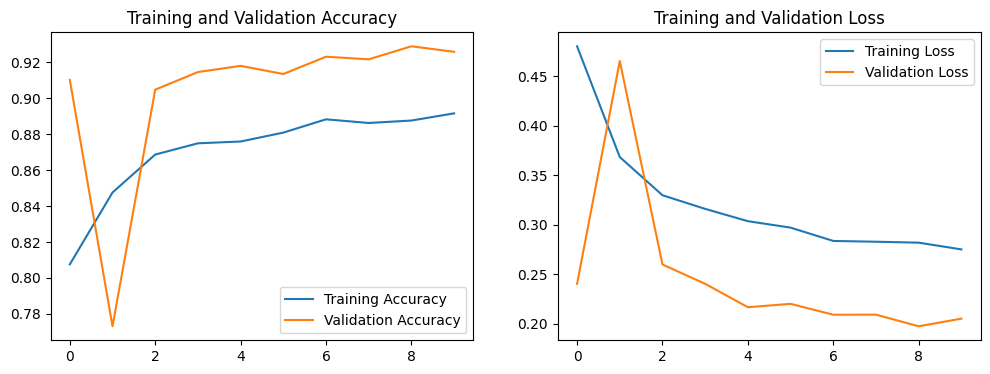

In [18]:
# Save the model
model.save('/content/drive/MyDrive/model.h5')

import matplotlib.pyplot as plt

# Assuming 'history' is the output from the 'fit' method
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


173/173 [==============================] - 14s 78ms/step


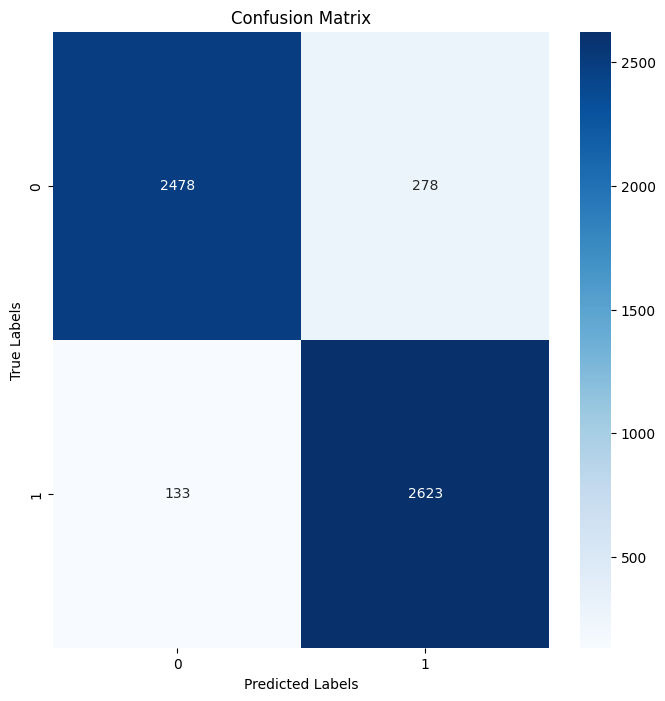

In [15]:
# Generate predictions
val_generator.reset()  # Resetting the generator
predictions = model.predict(val_generator, steps=np.ceil(val_generator.samples / BATCH_SIZE))

predicted_classes = np.argmax(predictions, axis=1)

# Ensure the length of predicted_classes matches the number of validation samples
predicted_classes = predicted_classes[:len(true_classes)]



# Retrieve the true class labels
true_classes = val_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
